# 实验报告
<font size=4>
    
+ **姓名：于成俊**
+ **学号：2112066**
+ **专业：密码科学与技术**

</font>

## 实验要求
    
<font size=4>
    

+ 基本要求(4’)：绘制聚类前后样本分布情况
    + 实现 single-linkage 层次聚类算法。
    + 实现 complete-linkage 层次聚类算法。
+ 中级要求(1’)：实现 average-linkage 层次聚类算法，绘制样本分布图。
+ 提⾼要求(1’)：对⽐上述三种算法，给出结论。
+ 拓展要求：通过变换聚类簇的个数，测试上述三种算法的性能，并给出分析。
</font>


## 实验流程

首先导入相关包

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import heapq

然后读取数据

In [34]:
# 读取数据
data = np.loadtxt("data.dat")
labels = np.loadtxt("label.dat")

再将数据进行标准化

In [35]:
# 标准化数据(确保各个特征在计算距离时对聚类的影响是平等的)
data_std = (data - np.mean(data, axis=0)) / np.std(data, axis=0)

**为了加快算法效率，我采用最小堆来存储簇之间的距离，这样找到最小距离的时间复杂度为O(1)。并在更新距离堆的过程中，我又用到了距离矩阵，这样可以直接通过索引，来找到两个clusters中所有点的距离的现成的值，就不需要每次都重新算所有点的欧几里得距离了。**

**注意:在此次实验中，我的距离矩阵有个特性，即有意义的数据的行索引是小于列索引的，所以我的距离矩阵类似于左下三角为0的矩阵。这样，在寻找其他簇与一个特定簇之间的距离会非常方便，只需遍历以该特定簇的索引为行索引的行，以及遍历以该特定簇的索引为列索引的列就行了**

### 基本要求
#### 实现 single-linkage 层次聚类算法：

single-linkage算法中更新距离堆的函数:

In [36]:
# single-linkage算法中更新距离堆
def update_heap_single(heap, x, y, length):
    # 存储距离的矩阵
    dist_matrix = np.zeros((length, length))
    # 创建一个新的空堆
    new_heap = []
    # 遍历旧堆中的每个元素
    for distance, i, j in heap:
        # 加入到距离矩阵
        dist_matrix[i][j] = distance
        # 如果元组中的索引不包含y且不包含x,则将其添加到新堆中
        if y not in (i, j) and x not in (i, j):
            if i > y:
                i = i - 1
            if j > y:
                j = j - 1
            heapq.heappush(new_heap, (distance, i, j))

    # 更新索引包含x不包含y的距离，并加入到新堆中
    # 遍历簇索引为x所在的行
    for j in range(x+1, length):
        # 因为接下来要删除被合并的簇，所以在其后面的簇的索引要减1
        if j > y:
            if(dist_matrix[x][j] < dist_matrix[y][j]):
                heapq.heappush(new_heap, (dist_matrix[x][j], x, j-1))
            else:
                heapq.heappush(new_heap, (dist_matrix[y][j], x, j - 1))
        # 如果簇在被合并的簇的前面，则它的索引不会受到影响
        if j < y:
            if (dist_matrix[x][j] < dist_matrix[j][y]):
                heapq.heappush(new_heap, (dist_matrix[x][j], x, j))
            else:
                heapq.heappush(new_heap, (dist_matrix[j][y], x, j))
    # 遍历簇索引为x所在的列
    for i in range(0, x):
        if(dist_matrix[i][x] < dist_matrix[i][y]):
            heapq.heappush(new_heap, (dist_matrix[i][x], i, x))
        else:
            heapq.heappush(new_heap, (dist_matrix[i][y], i, x))

    return new_heap

single-linkage 层次聚类算法函数:

In [37]:
#  实现 single-linkage 层次聚类算法
def single_linkage(data_std, labels, num):
    # 初始化每个数据点为一个簇
    clusters = [[point] for point in data_std]
    # 使用堆存储簇之间的距离信息来加快效率
    heap = []
    for i in range(len(clusters)):
        # 由于对称性，distances(i, j) = distances(j, i)。所以从 i + 1 开始，避免重复计算，提高了效率。
        for j in range(i + 1, len(clusters)):
            # 计算欧几里得距离
            distance = np.linalg.norm(clusters[i][0] - clusters[j][0])
            # 将元组加入堆中
            heapq.heappush(heap, (distance, i, j))

    # 层次聚类的过程
    while len(clusters) > num:
        # 找到最小值及相应的两个簇的索引
        min_distance, idx1, idx2 = heap[0]
        # 合并簇
        clusters[idx1].extend(clusters[idx2])
        # 更新堆
        heap = update_heap_single(heap, idx1, idx2, len(clusters))
        # 删除被合并的簇
        del clusters[idx2]

    # 绘制聚类前后样本分布情况

    fig = plt.figure(figsize=(10, 5))

    # 创建两个子图
    ax = [fig.add_subplot(121, projection='3d'), fig.add_subplot(122, projection='3d')]

    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

    # 聚类前
    ax[0].scatter(data_std[:, 0], data_std[:, 1], data_std[:, 2], c=[colors[int(label)] for label in labels])
    ax[0].set_title('Before Clustering')

    # 聚类后
    for i, cluster in enumerate(clusters):
        cluster = np.array(cluster)  # 将列表转换为numpy数组
        ax[1].scatter(cluster[:, 0], cluster[:, 1], cluster[:, 2], c=colors[i % len(colors)])

    ax[1].set_title('After Clustering')

    plt.show()

画出样本分布图，聚类簇的个数为4

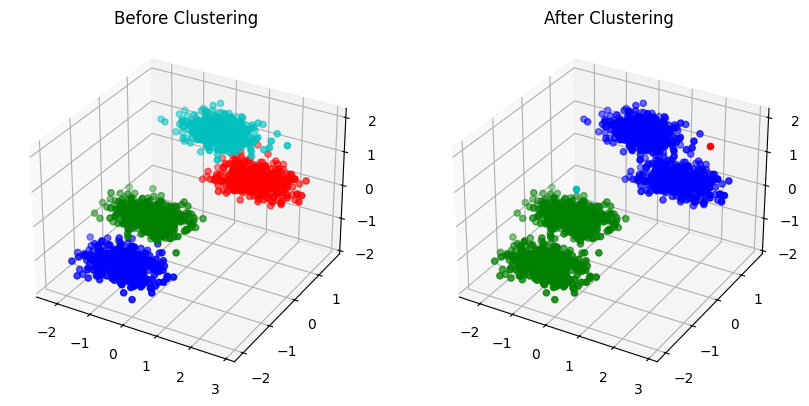

In [38]:
# 实现 single-linkage 层次聚类算法:
single_linkage(data_std, labels, 4)

#### 实现 complete-linkage 层次聚类算法：

complete-linkage算法中更新距离堆的函数:

In [39]:
# complete-linkage算法中更新距离堆
def update_heap_complete(heap, x, y, length):
    # 存储距离的矩阵
    dist_matrix = np.zeros((length, length))
    # 创建一个新的空堆
    new_heap = []
    # 遍历旧堆中的每个元素
    for distance, i, j in heap:
        # 加入到距离矩阵
        dist_matrix[i][j] = distance
        # 如果元组中的索引不包含y且不包含x,则将其添加到新堆中
        if y not in (i, j) and x not in (i, j):
            if i > y:
                i = i - 1
            if j > y:
                j = j - 1
            heapq.heappush(new_heap, (distance, i, j))

    # 更新索引包含x不包含y的距离，并加入到新堆中
    # 遍历簇索引为x所在的行
    for j in range(x+1, length):
        # 因为接下来要删除被合并的簇，所以在其后面的簇的索引要减1
        if j > y:
            if(dist_matrix[x][j] < dist_matrix[y][j]):
                heapq.heappush(new_heap, (dist_matrix[y][j], x, j - 1))
            else:
                heapq.heappush(new_heap, (dist_matrix[x][j], x, j - 1))
        # 如果簇在被合并的簇的前面，则它的索引不会受到影响
        if j < y:
            if (dist_matrix[x][j] < dist_matrix[j][y]):
                heapq.heappush(new_heap, (dist_matrix[j][y], x, j))
            else:
                heapq.heappush(new_heap, (dist_matrix[x][j], x, j))
    # 遍历簇索引为x所在的列
    for i in range(0, x):
        if(dist_matrix[i][x] < dist_matrix[i][y]):
            heapq.heappush(new_heap, (dist_matrix[i][y], i, x))
        else:
            heapq.heappush(new_heap, (dist_matrix[i][x], i, x))

    return new_heap

complete-linkage 层次聚类算法函数:

In [40]:
#  实现 complete-linkage 层次聚类算法
def complete_linkage(data_std, labels, num):
    # 初始化每个数据点为一个簇
    clusters = [[point] for point in data_std]
    # 使用堆存储簇之间的距离信息来加快效率
    heap = []
    for i in range(len(clusters)):
        # 由于对称性，distances(i, j) = distances(j, i)。所以从 i + 1 开始，避免重复计算，提高了效率。
        for j in range(i + 1, len(clusters)):
            # 计算欧几里得距离
            distance = np.linalg.norm(clusters[i][0] - clusters[j][0])
            # 将元组加入堆中
            heapq.heappush(heap, (distance, i, j))

    # 层次聚类的过程
    while len(clusters) > num:
        # 找到最小值及相应的两个簇的索引
        min_distance, idx1, idx2 = heap[0]
        # 合并簇
        clusters[idx1].extend(clusters[idx2])
        # 更新堆
        heap = update_heap_complete(heap, idx1, idx2, len(clusters))
        # 删除被合并的簇
        del clusters[idx2]

    # 绘制聚类前后样本分布情况

    fig = plt.figure(figsize=(10, 5))

    # 创建两个子图
    ax = [fig.add_subplot(121, projection='3d'), fig.add_subplot(122, projection='3d')]

    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

    # 聚类前
    ax[0].scatter(data_std[:, 0], data_std[:, 1], data_std[:, 2], c=[colors[int(label)] for label in labels])
    ax[0].set_title('Before Clustering')

    # 聚类后
    for i, cluster in enumerate(clusters):
        cluster = np.array(cluster)  # 将列表转换为numpy数组
        ax[1].scatter(cluster[:, 0], cluster[:, 1], cluster[:, 2], c=colors[i % len(colors)])

    ax[1].set_title('After Clustering')

    plt.show()

画出样本分布图，聚类簇的个数为4

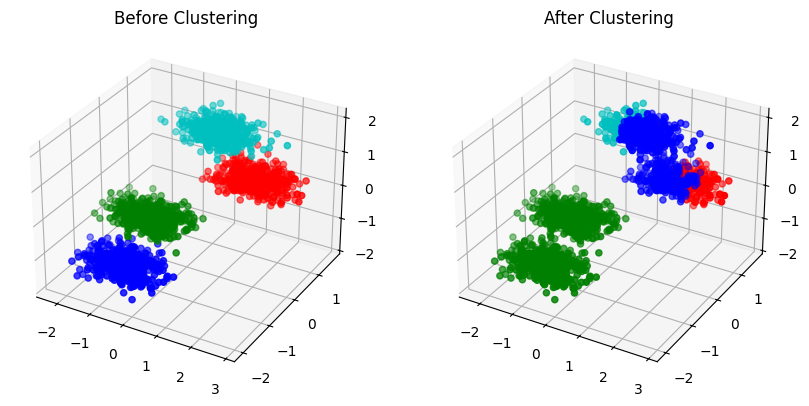

In [41]:
# 实现  complete-linkage 层次聚类算法:
complete_linkage(data_std, labels, 4)

### 中级要求
#### 实现 average-linkage 层次聚类算法：

average-linkage算法中更新距离堆的函数:

In [48]:
#  average-linkage算法中更新距离堆
def update_heap_average(heap, x, y, clusters):
    length = len(clusters)
    # 存储距离的矩阵
    dist_matrix = np.zeros((length, length))
    # 创建一个新的空堆
    new_heap = []
    # 遍历旧堆中的每个元素
    for distance, i, j in heap:
        # 加入到距离矩阵
        dist_matrix[i][j] = distance
        # 如果元组中的索引不包含y且不包含x,则将其添加到新堆中
        if y not in (i, j) and x not in (i, j):
            if i > y:
                i = i - 1
            if j > y:
                j = j - 1
            heapq.heappush(new_heap, (distance, i, j))

    # 更新索引包含x不包含y的距离，并加入到新堆中
    # 遍历簇索引为x所在的行
    for j in range(x+1, length):
        n1 = len(clusters[x])
        n2 = len(clusters[y])
        n3 = len(clusters[j])
        sum1 = dist_matrix[x][j] * n1 * n3
        # 因为接下来要删除被合并的簇，所以在其后面的簇的索引要减1
        if j > y:
            sum2 = dist_matrix[y][j] * n2 * n3
            distance = (sum1 + sum2) / (n1 * n3 + n2 * n3)
            heapq.heappush(new_heap, (distance, x, j - 1))
        # 如果簇在被合并的簇的前面，则它的索引不会受到影响
        if j < y:
            sum2 = dist_matrix[j][y] * n2 * n3
            distance = (sum1 + sum2) / (n1 * n3 + n2 * n3)
            heapq.heappush(new_heap, (distance, x, j))
    # 遍历簇索引为x所在的列
    for i in range(0, x):
        n1 = len(clusters[x])
        n2 = len(clusters[y])
        n3 = len(clusters[i])
        sum1 = dist_matrix[i][x] * n1 * n3
        sum2 = dist_matrix[i][y] * n2 * n3
        distance = (sum1 + sum2) / (n1 * n3 + n2 * n3)
        heapq.heappush(new_heap, (distance, i, x))

    return new_heap

average-linkage 层次聚类算法函数:(与上两个算法最大的不同就是，必须在更新距离堆之后再合并簇)

In [49]:
#  实现 average-linkage 层次聚类算法
def average_linkage(data_std, labels, num):
    # 初始化每个数据点为一个簇
    clusters = [[point] for point in data_std]
    # 使用堆存储簇之间的距离信息来加快效率
    heap = []
    for i in range(len(clusters)):
        # 由于对称性，distances(i, j) = distances(j, i)。所以从 i + 1 开始，避免重复计算，提高了效率。
        for j in range(i + 1, len(clusters)):
            # 计算欧几里得距离
            distance = np.linalg.norm(clusters[i][0] - clusters[j][0])
            # 将元组加入堆中
            heapq.heappush(heap, (distance, i, j))

    # 层次聚类的过程
    while len(clusters) > num:
        # 找到最小值及相应的两个簇的索引
        min_distance, idx1, idx2 = heap[0]
        # 更新堆
        heap = update_heap_average(heap, idx1, idx2, clusters)
         # 合并簇
        clusters[idx1].extend(clusters[idx2])
        # 删除被合并的簇
        del clusters[idx2]

    # 绘制聚类前后样本分布情况

    fig = plt.figure(figsize=(10, 5))

    # 创建两个子图
    ax = [fig.add_subplot(121, projection='3d'), fig.add_subplot(122, projection='3d')]

    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

    # 聚类前
    ax[0].scatter(data_std[:, 0], data_std[:, 1], data_std[:, 2], c=[colors[int(label)] for label in labels])
    ax[0].set_title('Before Clustering')

    # 聚类后
    for i, cluster in enumerate(clusters):
        cluster = np.array(cluster)  # 将列表转换为numpy数组
        ax[1].scatter(cluster[:, 0], cluster[:, 1], cluster[:, 2], c=colors[i % len(colors)])

    ax[1].set_title('After Clustering')

    plt.show()

画出样本分布图，聚类簇的个数为4

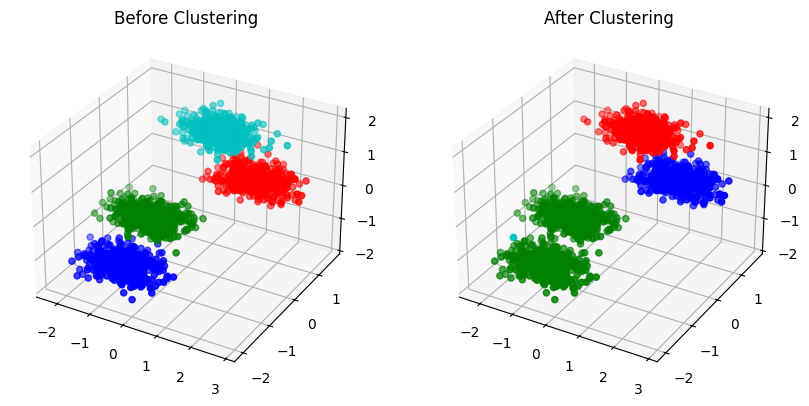

In [50]:
# 实现  average-linkage 层次聚类算法:
average_linkage(data_std, labels, 4)

**和提高要求中使用sklearn库实现的算法进行对比，可知以上自己实现的三种层次聚类算法是正确的**

### 提高要求

<font size=4>
以下是对这三种层次聚类算法优势、劣势和聚类效果的对比：

+ 单链接层次聚类算法：

    + 优势：能够处理非球形的簇和具有链式结构的数据。
    + 劣势：可能会产生“链式效应”，即形成一条由相距较远的对象组成的长链，这可能会导致聚类结果的不稳定。
    + 聚类效果：如果数据具有明显的链式结构，该方法的聚类效果可能会很好。

+ 全链接层次聚类算法：

    + 优势：倾向于生成紧凑的、球形的簇，这在某些应用中可能是理想的。
    + 劣势：可能会忽略数据中的自然结构，特别是当簇的形状不是球形时。
    + 聚类效果：如果数据的簇是紧凑和/或球形的，该方法的聚类效果可能会很好。

+ 平均链接层次聚类算法：

    + 优势：试图在单链接和全链接之间找到一种折中，生成的簇既不会像单链接那样链式，也不会像全链接那样紧凑。
    + 劣势：计算复杂度可能会比单链接和全链接更高，因为需要计算簇中所有点对之间的距离。
    + 聚类效果：如果数据的簇既不是链式的，也不是紧凑的，该方法的聚类效果可能会很好。
  
+ 总的来说，这三种方法各有优势和劣势，适用于不同的数据和问题。选择哪种方法取决于你的具体需求和数据的特性。
    + 如果你的数据有很强的链式结构，可能会倾向于使用单链接；
    + 如果你希望得到紧凑的簇，可能会选择全链接；
    + 如果你希望在这两者之间找到折中，可能会选择平均链接。
    + 但是，最好的做法通常是尝试不同的方法，看看哪种方法对处理数据和问题最有效。这三种方法都需要合适的距离度量和阈值选择，以得到最佳的聚类结果。在实际应用中，可能需要根据具体的数据和任务来调整这些参数。同时，由于这些方法都是基于距离的，因此对于高维数据，可能会受到“维度诅咒”的影响。在处理高维数据时，可能需要采取降维或者选择合适的距离度量来改善聚类效果。
</font>

### 拓展要求

为了测试方便，我又使用scikit-learn库实现了上述三种算法并计算轮廓系数和 Davies-Bouldin Index

导入相关包

In [51]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score

测试函数:

In [52]:
def test(data_std, num):
    # linkage 方法
    linkage_methods = ['single', 'complete', 'average']

    # 计算轮廓系数和 Davies-Bouldin Index
    for linkage_method in linkage_methods:
        # 层次聚类
        clustering = AgglomerativeClustering(n_clusters=num, linkage=linkage_method)
        prelabels = clustering.fit_predict(data_std)

        # 计算轮廓系数
        silhouette_avg = silhouette_score(data_std, prelabels)
        print(f"{linkage_method.capitalize()} Linkage - Silhouette Score: {silhouette_avg}")

        # 计算 Davies-Bouldin Index
        db_index = davies_bouldin_score(data_std, prelabels)
        print(f"{linkage_method.capitalize()} Linkage - Davies-Bouldin Index: {db_index}")

        fig = plt.figure(figsize=(10, 5))
        ax = fig.add_subplot(111, projection='3d');
        colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'purple', 'pink', 'slategrey']
        ax.scatter(data_std[:, 0], data_std[:, 1], data_std[:, 2], c=[colors[int(label)] for label in prelabels])
        ax.set_title('After Clustering')
        plt.show()

当聚类簇的个数为4时

Single Linkage - Silhouette Score: 0.23847676583652844
Single Linkage - Davies-Bouldin Index: 0.580309821264295


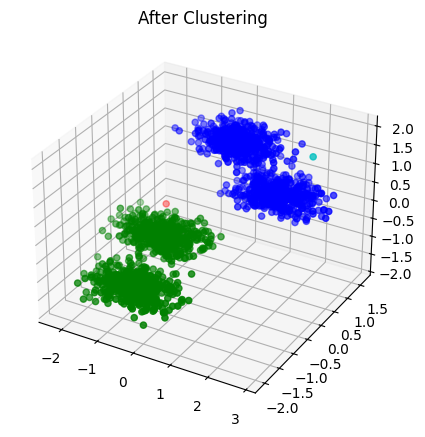

Complete Linkage - Silhouette Score: 0.3634268339619633
Complete Linkage - Davies-Bouldin Index: 0.8740262749434006


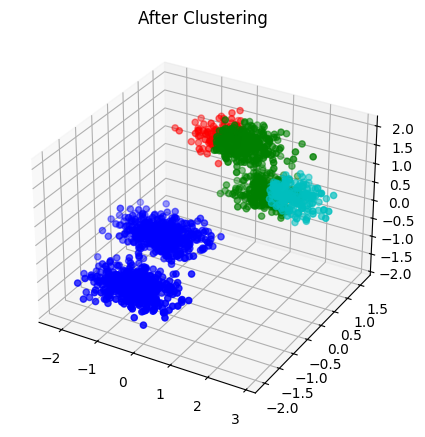

Average Linkage - Silhouette Score: 0.4331522022753816
Average Linkage - Davies-Bouldin Index: 0.588309448724018


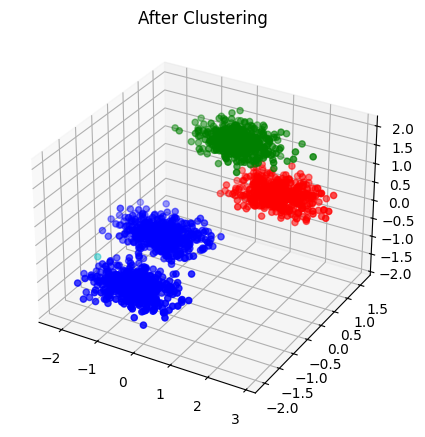

In [53]:
test(data_std, 4)

当聚类簇的个数为5时

Single Linkage - Silhouette Score: 0.1828458241360416
Single Linkage - Davies-Bouldin Index: 0.5653243921806803


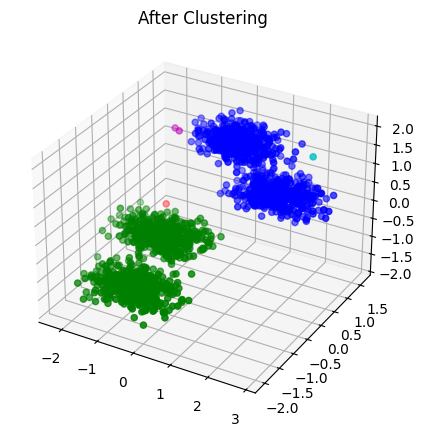

Complete Linkage - Silhouette Score: 0.168988428130514
Complete Linkage - Davies-Bouldin Index: 1.2728881787393393


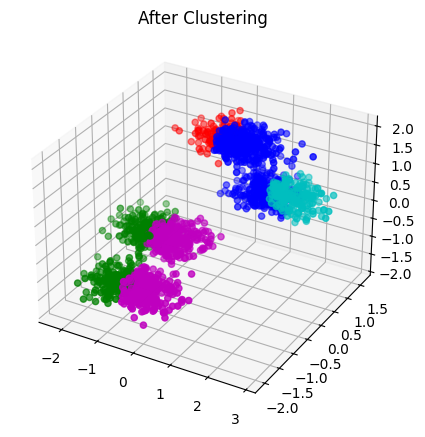

Average Linkage - Silhouette Score: 0.4856548414959931
Average Linkage - Davies-Bouldin Index: 0.6797714419288721


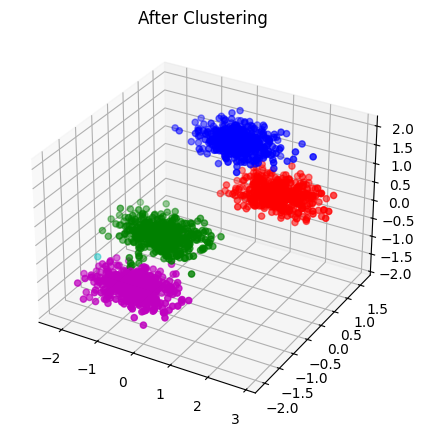

In [54]:
test(data_std, 5)

当聚类簇的个数为8时

Single Linkage - Silhouette Score: -0.024078012052462634
Single Linkage - Davies-Bouldin Index: 0.8439298558049312


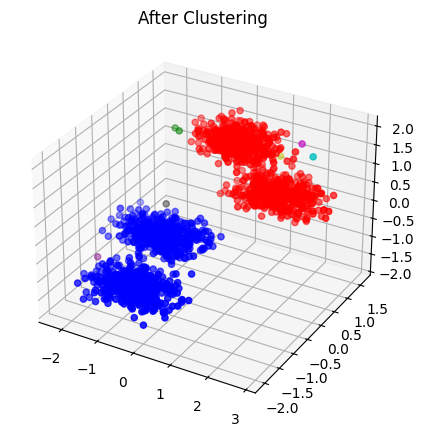

Complete Linkage - Silhouette Score: 0.33029902545480616
Complete Linkage - Davies-Bouldin Index: 0.9985533466149253


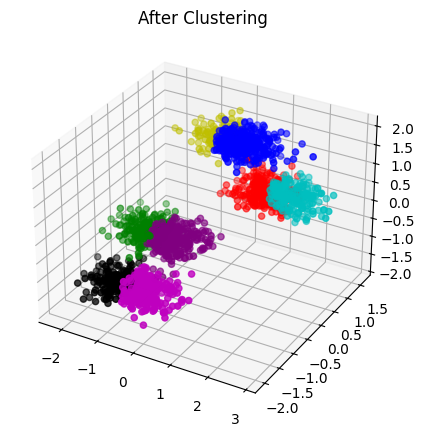

Average Linkage - Silhouette Score: 0.3637388329723336
Average Linkage - Davies-Bouldin Index: 0.74794010043047


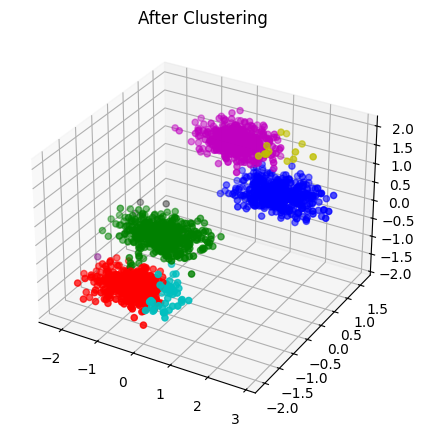

In [55]:
test(data_std, 8)

当聚类簇的个数为10时

Single Linkage - Silhouette Score: -0.11320905916719479
Single Linkage - Davies-Bouldin Index: 0.805219580838911


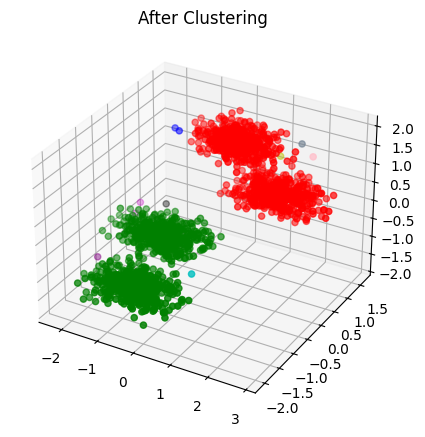

Complete Linkage - Silhouette Score: 0.2956081717716251
Complete Linkage - Davies-Bouldin Index: 1.0720186772334335


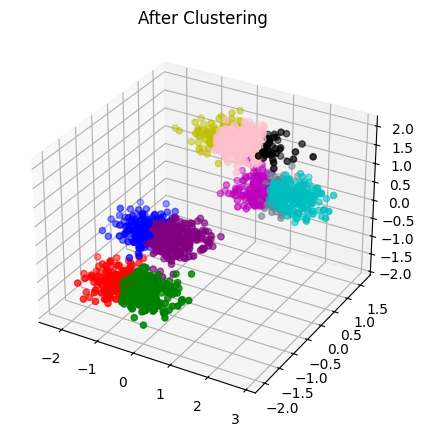

Average Linkage - Silhouette Score: 0.3415171763262761
Average Linkage - Davies-Bouldin Index: 0.8213565907612221


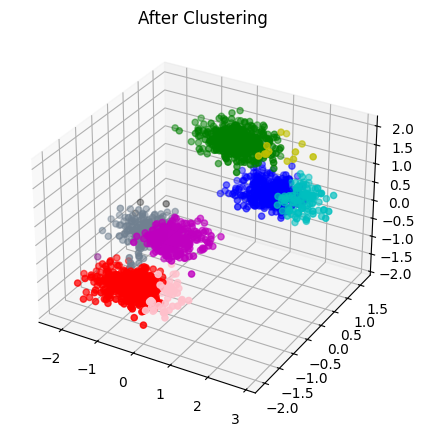

In [56]:
test(data_std, 10)

通过上面可知：随着聚类个数的增多，Single Linkage的轮廓系数越来越小，说明分类越来越错误；Complete Linkage的轮廓系数来回波动；Average Linkage
的轮廓系数较稳定。从Davies-Bouldin Index可以看出单链接聚类可能更倾向于形成长条形簇，而完全链接聚类可能更倾向于形成更紧凑的簇，平均链接聚类是这两者的折中。从分类视觉角度看，SingleLinkage层次聚类效果最差，有的类只有几个点。